# Rice Data Science Conference 2017--Basic Poster Figures
Build the easy figures to be included in my poster for the 2017 Data Science Conference at Rice

In [227]:
import os
import glob
import urllib
import datetime
import random

import pandas
import numpy as np
from scipy.interpolate import splev,splrep
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import ticker
import sunpy
from sunpy.map import Map
from sunpy.net import vso
from sunpy.database import database
from sunpy.database.tables import display_entries
import astropy.units as u
import astropy.constants as const
import astropy.table
import seaborn.apionly as sns
sns.set_palette('deep')

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

## Coronal Heating + Introduction
Pull in the relevant info to download the AIA images for the first example image. We want to make a composite map of a few different channels.

In [2]:
tmp = (urllib.request.urlopen('http://iopscience.iop.org/0004-637X/759/2/141/suppdata/apj446760t1_ascii.txt')
                     .readlines())
col_names = tmp[3].decode('utf8').strip().split('\t')
raw_table = [t.decode('utf8').strip().split('\t') for t in tmp[4:-3]]
ar_catalogue = pandas.DataFrame(data=raw_table,columns=col_names)
ar_catalogue['Date'] = pandas.to_datetime(ar_catalogue['Date'])
ar_catalogue['X_cen'] = pandas.to_numeric(ar_catalogue['X_cen'])
ar_catalogue['Y_cen'] = pandas.to_numeric(ar_catalogue['Y_cen'])
ar_catalogue = astropy.table.QTable.from_pandas(ar_catalogue)
ar_catalogue['X_cen'].unit = u.arcsec
ar_catalogue['Y_cen'].unit = u.arcsec

We only really care about the second row, NOAA 1158.

In [3]:
ar_catalogue[1]

Region,NOAA,Date,X_cen,Y_cen,A_M,Phi_M,I_hot,alpha,beta,EIS File
,,,arcsec,arcsec,,,,,,
str2,str4,datetime64[ns],float64,float64,str8,str8,str8,str7,str8,str22
2,1158,2011-02-12T15:32:13.000000000,-248.4,-211.8,3.04(19),4.22(21),1.88(04),2.7,6.8,eis_l1_20110212_143019


Query the VSO for the needed AIA and HMI data.

In [4]:
def convert_npdt_to_str(npdt):
    # assumes ns
    return datetime.datetime.utcfromtimestamp(npdt.astype(datetime.datetime)*1e-9).strftime("%Y/%m/%d %H:%M:%S")

In [5]:
channel_nos = [94,131,171,193,211,335]

In [6]:
client = vso.VSOClient()

In [7]:
dt = 100
start_time = convert_npdt_to_str(ar_catalogue[1]['Date'] - np.timedelta64(dt,'s'))
end_time = convert_npdt_to_str(ar_catalogue[1]['Date'] + np.timedelta64(dt,'s'))

In [8]:
q_aia = client.query(
    vso.attrs.Time(start_time,end_time),
    vso.attrs.Instrument('AIA'),
    vso.attrs.Wave(93*u.angstrom,336*u.angstrom)
)

In [9]:
q_hmi = client.query(
    vso.attrs.Time(start_time,end_time),
    vso.attrs.Instrument('HMI'),
    vso.attrs.Physobs('LOS_magnetic_field')
)

In [10]:
vso_results = client.get(q_aia).wait() + client.get(q_hmi).wait()

In [166]:
# Avoid downloading the data again
vso_results = glob.glob('/storage-home/w/wtb2/sunpy/data/aia*.fits') + glob.glob('/storage-home/w/wtb2/sunpy/data/hmi*.fits')

Select the range over which we want to crop.

In [167]:
crop_range = (base_field.hmi_map.xrange,base_field.hmi_map.yrange)

Now look at each channel.

In [168]:
aia_results = {int(v.split('_')[2][:-1]):v for v in vso_results if 'aia' in v}
hmi_results = [v for v in vso_results if 'hmi' in v]

Maybe instead of a composite map, just provide a global picture (in a single channel) with a zoomed in view of NOAA 1158 (in the same channel).

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/sunpy/wcs/wcs.py:232: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(rsun_meters ** 2 - x ** 2 - y ** 2)
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/colors.py:1115: RuntimeWarn

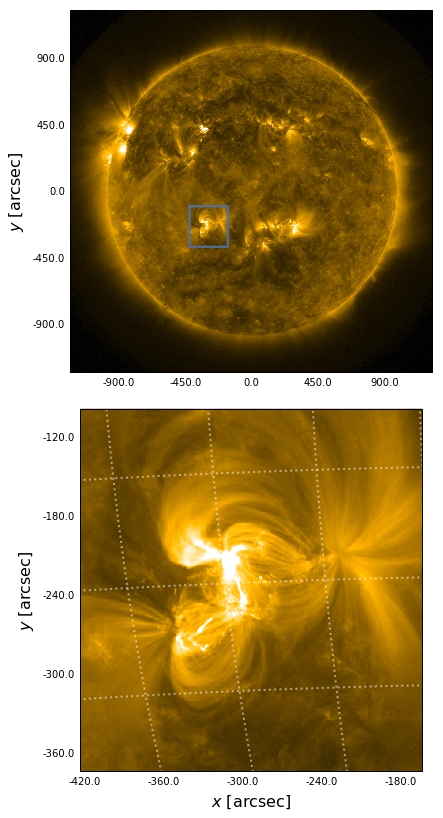

In [222]:
fig = plt.figure(figsize=(8,14))
plt.subplots_adjust(hspace=0.1)
plot_options = {'annotate':False,'title':False,
                'norm':matplotlib.colors.PowerNorm(0.5,vmin=0,vmax=3e3)}
# fulldisk map
fulldisk_map = Map(aia_results[171])
ax1 = fig.add_subplot(211,projection=fulldisk_map)
fulldisk_map.plot(axes=ax1,**plot_options)
## add rectangle
width = np.diff(crop_range[0])
height = np.diff(crop_range[1])
left_corner = u.Quantity((crop_range[0][0],crop_range[1][0]))
fulldisk_map.draw_rectangle(left_corner,width,height,lw=2,color=sns.color_palette()[0])
# zoomed in region
zoom_map = Map(aia_results[171]).submap(*crop_range)
ax2 = fig.add_subplot(212,projection=zoom_map)
#plot_options['norm'] = matplotlib.colors.Normalize(vmin=1,vmax=3e3)
zoom_map.plot(axes=ax2,**plot_options)
zoom_map.draw_grid(axes=ax2,grid_spacing=5*u.deg,alpha=0.5)
# aesthetics
ax1.coords[0].grid(alpha=0)
ax1.coords[1].grid(alpha=0)
ax2.coords[0].grid(alpha=0)
ax2.coords[1].grid(alpha=0)
ax1.coords[0].set_ticklabel(size=plt.rcParams['xtick.labelsize'])
ax1.coords[1].set_ticklabel(size=plt.rcParams['ytick.labelsize'])
ax2.coords[0].set_ticklabel(size=plt.rcParams['xtick.labelsize'])
ax2.coords[1].set_ticklabel(size=plt.rcParams['ytick.labelsize'])
ax1.coords[1].set_axislabel(r'$y$ [$\mathrm{{{}}}$]'.format(u.Unit(hmi_map.meta['cunit2'])),
                           size=plt.rcParams['axes.labelsize'])
ax2.coords[0].set_axislabel(r'$x$ [$\mathrm{{{}}}$]'.format(u.Unit(hmi_map.meta['cunit1'])),
                           size=plt.rcParams['axes.labelsize'])
ax2.coords[1].set_axislabel(r'$y$ [$\mathrm{{{}}}$]'.format(u.Unit(hmi_map.meta['cunit2'])),
                           size=plt.rcParams['axes.labelsize'])
fig.savefig('../figures/fulldisk_plus_zoom_171.pdf',)

## Loop Hydrodynamics

Load all of fields for the heating models and plot a sample $T(t)$ and $n(t)$ curve from each.

In [25]:
cooling_field = synthesizAR.Skeleton.restore('/storage-home/w/wtb2/data/noaa1158_cooling_model/field_checkpoint/') 
hf_field = synthesizAR.Skeleton.restore('/storage-home/w/wtb2/data/noaa1158_high_frequency/field_checkpoint/')
if_field = synthesizAR.Skeleton.restore('/storage-home/w/wtb2/data/noaa1158_intermediate_frequency/field_checkpoint/')
lf_field = synthesizAR.Skeleton.restore('/storage-home/w/wtb2/data/noaa1158_low_frequency/field_checkpoint/')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-10-05 14:02:26,002 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-10-05 14:02:26,003 Parameters: domain_dimensions         = [95 96 96]
yt : [INFO     ] 2017-10-05 14:02:26,003 Parameters: domain_left_edge          = [ -2.96081016e+10  -2.62091384e+10   3.91869796e+08]
yt : [INFO     ] 2017-10-05 14:02:26,004 Parameters: domain_right_edge         = [ -1.18463315e+10  -7.41270210e+09   1.92016200e+10]
yt : [INFO     ] 2017-10-05 14:02:26,005 Parameters: cosmological_simulation   = 0.0
No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-10-05 14:02:35,700 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-10-05 14:02:35,701 Parameters: domain_dimensions         = [95 96 96]
yt : [INFO     ] 2017-10-05 14:02:35,702 Parameters: domain_left_edge          = [ -2.96081016e+10  -2.62091384e+10   3.91869796e+08]
yt : [INFO     ] 2017

In [28]:
for loop in cooling_field.loops:
    loop.parameters_savefile = '/storage-home/w/wtb2/data/noaa1158_cooling_model/loop_parameters.h5'

999


/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


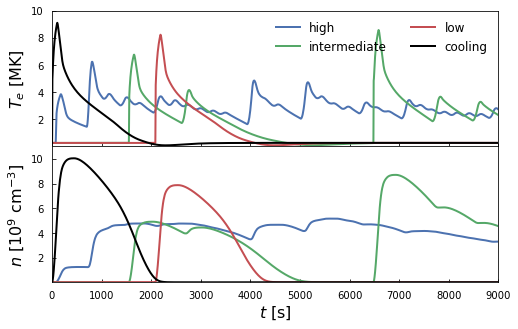

In [230]:
fig,axes = plt.subplots(2,1,figsize=(8,5),sharex=True)
plt.subplots_adjust(hspace=0.)
i_loop = np.random.randint(low=0,high=1e4,)
i_loop = 999
print(i_loop)
# temperature
axes[0].plot(hf_field.loops[i_loop].time,hf_field.loops[i_loop].electron_temperature[:,0].to(u.MK),label='high')
axes[0].plot(if_field.loops[i_loop].time,if_field.loops[i_loop].electron_temperature[:,0].to(u.MK),label='intermediate')
axes[0].plot(lf_field.loops[i_loop].time,lf_field.loops[i_loop].electron_temperature[:,0].to(u.MK),label='low')
axes[0].plot(cooling_field.loops[i_loop].time,cooling_field.loops[i_loop].electron_temperature[:,0].to(u.MK),
             color='k',label='cooling')
# density
axes[1].plot(hf_field.loops[i_loop].time,hf_field.loops[i_loop].density[:,0]/1e9)
axes[1].plot(if_field.loops[i_loop].time,if_field.loops[i_loop].density[:,0]/1e9)
axes[1].plot(lf_field.loops[i_loop].time,lf_field.loops[i_loop].density[:,0]/1e9)
axes[1].plot(cooling_field.loops[i_loop].time,cooling_field.loops[i_loop].density[:,0]/1e9,color='k')
# aesthetics
axes[0].set_xlim([0,0.9e4])
axes[0].set_ylim([0,10])
axes[1].set_ylim([0,11])
axes[1].set_xlabel(r'$t$ [s]')
axes[0].set_ylabel(r'$T_e$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[0].tick_params(axis='both',direction='in')
axes[1].tick_params(axis='both',direction='in')
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=len(axes[0].get_yticklabels()),prune='lower'))
axes[1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=len(axes[1].get_yticklabels()),prune='lower'))
axes[0].legend(loc=0,frameon=False,ncol=2)
fig.savefig('../figures/hydrodynamic_nT')

## Forward Modeling

Now, load in the base field and overplot the fieldlines. Use every 10th streamline. We'll use the higher resolution HMI image.

In [12]:
base_field = synthesizAR.Skeleton.restore('../../../../data/base_noaa1158/')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-10-05 13:43:37,911 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-10-05 13:43:37,911 Parameters: domain_dimensions         = [95 96 96]
yt : [INFO     ] 2017-10-05 13:43:37,912 Parameters: domain_left_edge          = [ -2.96081016e+10  -2.62091384e+10   3.91869796e+08]
yt : [INFO     ] 2017-10-05 13:43:37,913 Parameters: domain_right_edge         = [ -1.18463315e+10  -7.41270210e+09   1.92016200e+10]
yt : [INFO     ] 2017-10-05 13:43:37,914 Parameters: cosmological_simulation   = 0.0


In [233]:
hmi_map = Map(hmi_results[0]).rotate().submap(base_field.hmi_map.xrange,base_field.hmi_map.yrange)
hmi_map.data = np.where(np.fabs(hmi_map.data)<50,np.nan,hmi_map.data)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/sunpy/image/transform.py:130: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


In [14]:
streamlines = [s[0] for s in base_field.streamlines]
random.shuffle(streamlines)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


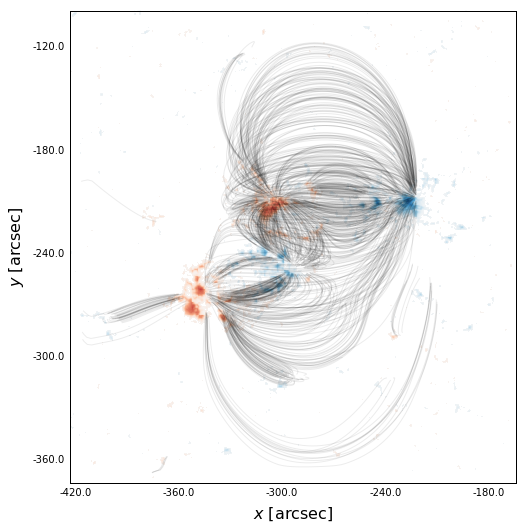

In [235]:
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(111,projection=hmi_map)
im = hmi_map.plot(axes=ax,annotate=False,title=False,cmap=plt.get_cmap('RdBu'),vmin=-2000,vmax=2000)
# axes and tick label sizing
ax.coords[0].set_ticklabel(size=plt.rcParams['xtick.labelsize'])
ax.coords[1].set_ticklabel(size=plt.rcParams['ytick.labelsize'])
ax.coords[0].set_axislabel(r'$x$ [$\mathrm{{{}}}$]'.format(u.Unit(hmi_map.meta['cunit1'])),
                           size=plt.rcParams['axes.labelsize'])
ax.coords[1].set_axislabel(r'$y$ [$\mathrm{{{}}}$]'.format(u.Unit(hmi_map.meta['cunit2'])),
                           size=plt.rcParams['axes.labelsize'])
# grids and tick sizing
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
for s in streamlines[::10]:
    ax.plot(base_field._convert_angle_to_length(s[:,0]*u.cm,working_units=u.arcsec).to(u.deg),
            base_field._convert_angle_to_length(s[:,1]*u.cm,working_units=u.arcsec).to(u.deg),
            alpha=0.075,transform=ax.get_transform('world'),color='k',lw=1
           )
fig.savefig('../figures/hmi_map_with_strands.pdf')

Create an AIA instrument and plot the response functions.

In [236]:
aia = InstrumentSDOAIA([0,3e4]*u.s)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


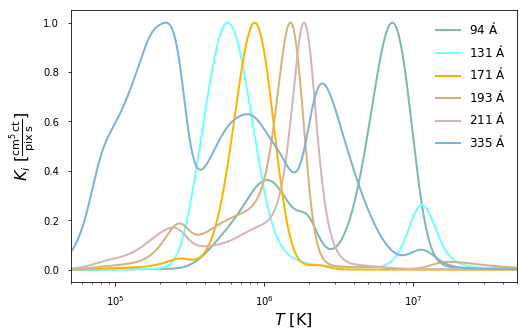

In [237]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
resp_temperature = np.logspace(4,9,1000)*u.K
for channel in aia.channels:
    color = sunpy.cm.cmlist['sdoaia{}'.format(channel['name'])](0.7)
    k = splev(resp_temperature.value,channel['temperature_response_spline'])*u.count*u.cm**5/u.s/u.pixel
    ax.plot(resp_temperature,k/k.max(),label=r'{} $\mathrm{{\mathring{{A}}}}$'.format(channel['name']),color=color)
ax.set_xscale('log')
ax.set_xlim([5e4,5e7])
ax.set_xlabel(r'$T$ [{:latex}]'.format(resp_temperature.unit))
ax.set_ylabel(r'$K_i$ [{:latex}]'.format(k.unit))
ax.legend(loc=0,frameon=False,ncol=1)
fig.savefig('../figures/aia_response_functions.pdf')

## Synthesized AIA Intensities

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


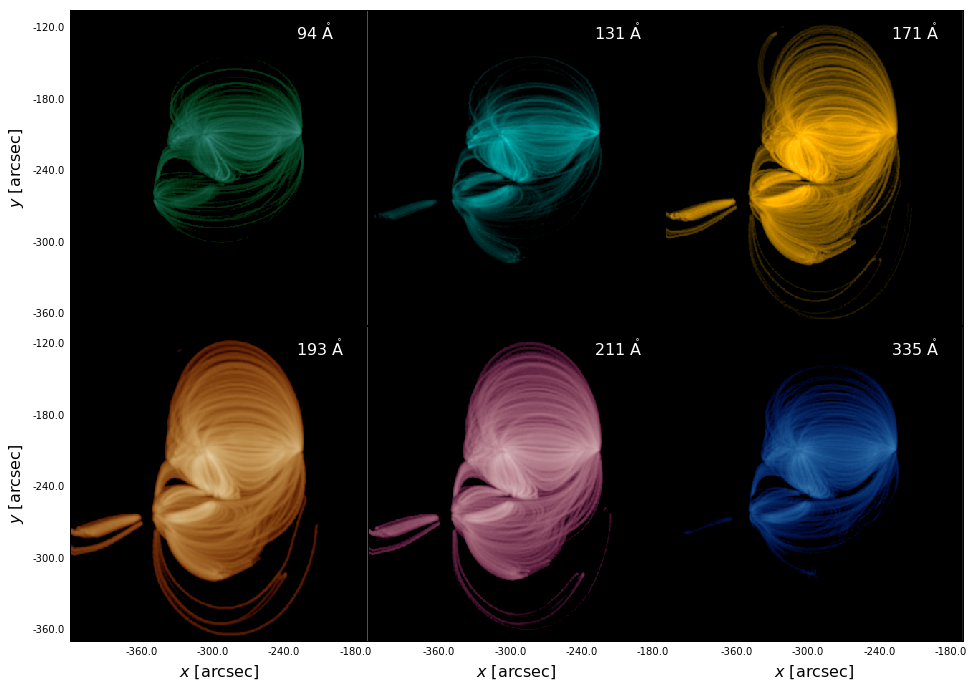

In [238]:
obs_time_index = np.where(aia.observing_time==1e4*u.s)[0][0]
fig = plt.figure(figsize=(16,11.63))
plt.subplots_adjust(wspace=0.,hspace=0.)
for i,chan in enumerate(aia.channels):
    tmp = Map(os.path.join('/storage-home/w/wtb2/data/noaa1158_low_frequency/'
                           +'SDO_AIA/{}/map_t{:06d}.fits'.format(chan['name'],obs_time_index)))
    ax = fig.add_subplot(2,3,i+1,projection=tmp)
    tmp.plot(annotate=False, norm=matplotlib.colors.SymLogNorm(1e-3,vmin=1,vmax=2e4))
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.coords[0].set_ticks_visible(False)
    ax.coords[1].set_ticks_visible(False)
    ax.coords[0].set_ticklabel(size=plt.rcParams['xtick.labelsize'])
    ax.coords[1].set_ticklabel(size=plt.rcParams['ytick.labelsize'])
    if i%3==0:
        ax.coords[1].set_axislabel(r'$y$ [arcsec]',size=plt.rcParams['axes.labelsize'])
    else:
        ax.coords[1].set_ticklabel_visible(False)
    if i>2:
        ax.coords[0].set_axislabel(r'$x$ [arcsec]',size=plt.rcParams['axes.labelsize'])
    else:
        ax.coords[0].set_ticklabel_visible(False)
    xtext,ytext = tmp.data_to_pixel(-230*u.arcsec,-130*u.arcsec)
    ax.text(xtext.value,ytext.value,
            r'${}$ $\mathrm{{\mathring{{A}}}}$'.format(chan['name']),
            color='w',fontsize=16)
fig.savefig('../figures/aia_intensities.pdf')

## Heating Models
Plot distributions of heating events for each heating model.

In [239]:
heating_rates = {n:[] for n in ['high','intermediate','low']}

In [240]:
# high
for loop in hf_field.loops:
    max_rate = (0.3*loop.field_strength.max().value)**2/8./np.pi/100.0
    heating_rates['high'] += (np.array([e['event']['magnitude'] 
                                       for e in loop.hydro_configuration['heating']['events']])/max_rate).tolist()
# intermediate
for loop in if_field.loops:
    max_rate = (0.3*loop.field_strength.max().value)**2/8./np.pi/100.0
    heating_rates['intermediate'] += (np.array([e['event']['magnitude'] 
                                               for e in loop.hydro_configuration['heating']['events']])/max_rate).tolist()
# low
for loop in lf_field.loops:
    max_rate = (0.3*loop.field_strength.max().value)**2/8./np.pi/100.0
    heating_rates['low'] += (np.array([e['event']['magnitude'] 
                                      for e in loop.hydro_configuration['heating']['events']])/max_rate).tolist()

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


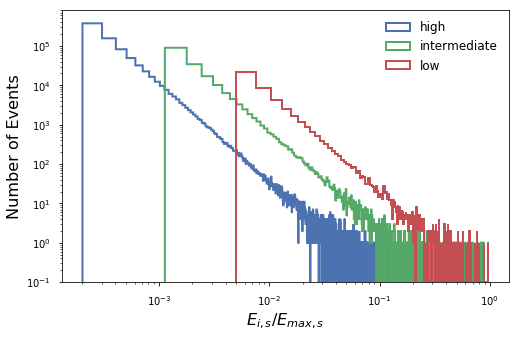

In [242]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
params = {'histtype':'step',
          'lw':2,
          'bins':'scott',#np.logspace(-6,1,100),
          'log':True,
          'normed':False}
for k in ['high','intermediate','low']:
    ax.hist(heating_rates[k],label=k,**params)
ax.set_xscale('log')
ax.legend(loc=1,frameon=False)
ax.set_ylabel(r'Number of Events')
ax.set_xlabel(r'$E_{i,s}/E_{max,s}$')
fig.savefig('../figures/heating_rate_distributions.pdf')